In [348]:
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json 
import os
import patsy
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
%matplotlib inline

def build_columns(df, lis):
    "appends columns to a dataframe with the names from a list"
    for x in lis:
        df[x] = 0

def dummy_column(df, column):
    for x in range(len(df[column])):
        if column in df['mechanics'][x]:
            df[column][x] = 1

def pop_columns(df, lis):
    "populates columns for dummy variables. can do this with patsy instead"
    for x in lis:
        dummy_column(df, x)

In [6]:
df = pd.read_json('bbgmid.json')

### Cleaning up the Data

Cleaning up some of the data - next time I should just use re and applymap across the board

In [7]:
df['rank'] = df['rank'].str.replace(',', '')

In [8]:
df['retail'] = df['retail'].str.replace('$', '')
df['retail'] = df['retail'].str.replace(',', '')
df['ebay'] = df['ebay'].str.replace('$', '')
df['ebay'] = df['ebay'].str.replace(',', '')
df['ebay'] = df['ebay'].replace('', np.nan)
df['retail'] = df['retail'].replace('', np.nan)
df['rank'] = df['rank'].astype('int')
df['ebay'] = df['ebay'].astype('float64')
df['retail'] = df['retail'].astype('float64')

In [9]:
df = df.drop('url', 1)

In [12]:
df= df.reset_index()

The text for average time is a range and not currently usable as a feature. Let's calculate the average of it or if it's only 1 number just return that number 

In [579]:
df['avg_time'] = 0


In [15]:
for x in range(len(df['time'])):
    if len(df['time'].str.split('–')[x])>1:
        df['avg_time'][x] = (int(df['time'].str.split('–')[x][1])+int(df['time'].str.split('–')[x][0]))/2.0
    else:
        df['avg_time'][x] = df['time'][x]

/Users/leangchaing/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/leangchaing/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [16]:
df = df.drop('time', 1)

In [17]:
#get list of mechs
mechs = []
with open('mechanism.csv') as f:
    for x in f:
        mechs.append(x.strip())
mechs [0] = 'Acting'

In [18]:
print(mechs)

['Acting', 'Action/Movement Programming', 'Action Point Allowance System', 'Area control/Area influence', 'Area Enclosure', 'Area Movement', 'Area-Impulse', 'Auction/Bidding', 'Betting/Wagering', 'Campaign/Battle Card Driven', 'Card Drafting', 'Chit-Pull System', 'Co-operative Play', 'Commodity Speculation', 'Crayon Rail System', 'Deck/Pool Building', 'Dice Rolling', 'Grid movement', 'Hand Management', 'Hex-and-Counter', 'Line Drawing', 'Memory', 'Modular Board', 'Paper-and-Pencil', 'Partnerships', 'Pattern Building', 'Pattern Recognition', 'Pick-up and Deliver', 'Player elimination', 'Point to Point Movement', 'Press your Luck', 'Rock-Paper-Scissors', 'Role Playing', 'Roll/Spin and Move', 'Route/Network building', 'Secret Unit Deployment', 'Set Collection', 'Simulation', 'Simultaneous Action Selection', 'Singing', 'Stock Holding', 'Storytelling', 'Take That', 'Tile Placement', 'Time Track', 'Trading', 'Trick-taking', 'Variable Phase Order', 'Variable Player Powers', 'Voting', 'Worker 

In [20]:
build_columns(df, mechs)
pop_columns(df, mechs)

/Users/leangchaing/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
mech2 = ["Action / Movement Programming", "Area Control / Area Influence", "Campaign / Battle Card Driven", "Deck / Pool Building", "Grid Movement", "Player Elimination", "Press Your Luck","Roll / Spin and Move", "Route/Network Building"] 

In [22]:
df = df.drop(df.columns[df.sum(axis=0) == 0], 1)


In [23]:
build_columns(mech2)
pop_columns(mech2)

/Users/leangchaing/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
df.sum()

index                                                                      1405326
complexity                                                                 3104.96
ebay                                                                       4224.74
game_type                        [Uncategorized, Uncategorized, Uncategorized, ...
mechanics                        [Auction/Bidding, Card Drafting, Hand Manageme...
rank                                                                      16668931
rating                                                                      9960.8
retail                                                                      2007.2
title                            eBay: The Card GameAlpen RouletteBountyPiction...
year                             (2001)(1972)(2000)(1987)(2006)(1974)(1988)(200...
avg_time                                                                    165311
Acting                                                                          22
Acti

In [25]:
df.columns = map(str.lower, df.columns)
df.columns = [x.strip().replace (' ', '_') for x in df.columns]

In [27]:
df.columns

Index(['index', 'complexity', 'ebay', 'game_type', 'mechanics', 'rank',
       'rating', 'retail', 'title', 'year', 'avg_time', 'acting',
       'action_point_allowance_system', 'area_enclosure', 'area_movement',
       'area-impulse', 'auction/bidding', 'betting/wagering', 'card_drafting',
       'chit-pull_system', 'co-operative_play', 'commodity_speculation',
       'crayon_rail_system', 'dice_rolling', 'hand_management',
       'hex-and-counter', 'line_drawing', 'memory', 'modular_board',
       'paper-and-pencil', 'partnerships', 'pattern_building',
       'pattern_recognition', 'pick-up_and_deliver', 'point_to_point_movement',
       'rock-paper-scissors', 'role_playing', 'secret_unit_deployment',
       'set_collection', 'simulation', 'simultaneous_action_selection',
       'singing', 'stock_holding', 'storytelling', 'take_that',
       'tile_placement', 'time_track', 'trading', 'trick-taking',
       'variable_phase_order', 'variable_player_powers', 'voting',
       'worker_pla

In [347]:
df_new = df.drop(['game_type', 'mechanics'], 1)

ValueError: labels ['game_type' 'mechanics'] not contained in axis

In [29]:
df_new['year'] = df_new['year'].str.replace('(', "")
df_new['year'] = df_new['year'].str.replace(')', "")
df_new['year'] = df_new['year'].astype('str')

In [31]:
df_new['mech_ct'] = df['mechanics'].apply(lambda x: len(x))

In [32]:
df_new.head()

,index,complexity,ebay,rank,rating,retail,title,year,avg_time,acting,...,action_/_movement_programming,area_control_/_area_influence,campaign_/_battle_card_driven,deck_/_pool_building,grid_movement,player_elimination,press_your_luck,roll_/_spin_and_move,route/network_building,mech_ct
0,0,2.00,NaN,12326,5.2,NaN,eBay: The Card Game,2001,45,0,...,0,0,0,0,0,0,0,0,0,4
1,1,1.00,NaN,12323,5.0,NaN,Alpen Roulette,1972,5,0,...,0,0,0,0,0,0,0,0,0,1
2,2,1.63,NaN,12330,5.3,NaN,Bounty,2000,60,0,...,0,0,0,0,0,0,0,0,0,1
3,3,1.17,NaN,12320,4.9,NaN,Pictionary: Bible,1987,90,0,...,0,0,0,0,0,0,0,0,0,2
4,4,1.40,NaN,12329,5.2,NaN,Twisted Fish,2006,30,0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
df_new = df_new.drop(labels = ['rank', 'index'], axis = 1)

In [34]:
rat = df_new['rating']

df_new = df_new.drop('rating', 1)

df_new.insert(0, 'rating', rat)

In [35]:
df_new.to_pickle('bbgmid')

Adding in newboard game data that I rescraped and cleaned up using the processes above 

In [36]:
df2 = pd.read_pickle('games_mech_v3') 

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 59 columns):
title                            4372 non-null object
rating                           4372 non-null float64
complexity                       4372 non-null float64
ebay                             2010 non-null float64
retail                           1277 non-null float64
year                             4372 non-null int64
avg_time                         4372 non-null int64
acting                           4372 non-null int64
action_point_allowance_system    4372 non-null int64
area_enclosure                   4372 non-null int64
area_movement                    4372 non-null int64
area-impulse                     4372 non-null int64
auction/bidding                  4372 non-null int64
betting/wagering                 4372 non-null int64
card_drafting                    4372 non-null int64
chit-pull_system                 4372 non-null int64
co-operative_play                437

In [41]:
df = df_new.append(df2)

In [608]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6042 entries, 0 to 4371
Data columns (total 58 columns):
rating                           6042 non-null float64
complexity                       6042 non-null float64
avg_time                         6042 non-null int64
year                             6042 non-null int64
mech_ct                          6042 non-null int64
retail                           1339 non-null float64
ebay                             2130 non-null float64
acting                           6042 non-null int64
action_movement_programming      6042 non-null int64
action_point_allowance_system    6042 non-null int64
area_impulse                     6042 non-null int64
area_control_area_influence      6042 non-null int64
area_enclosure                   6042 non-null int64
area_movement                    6042 non-null int64
auction_bidding                  6042 non-null int64
betting_wagering                 6042 non-null int64
campaign_battle_card_driven      6042

In [43]:
df.to_pickle('games_v4')

### EDA 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136d45b38>]], dtype=object)

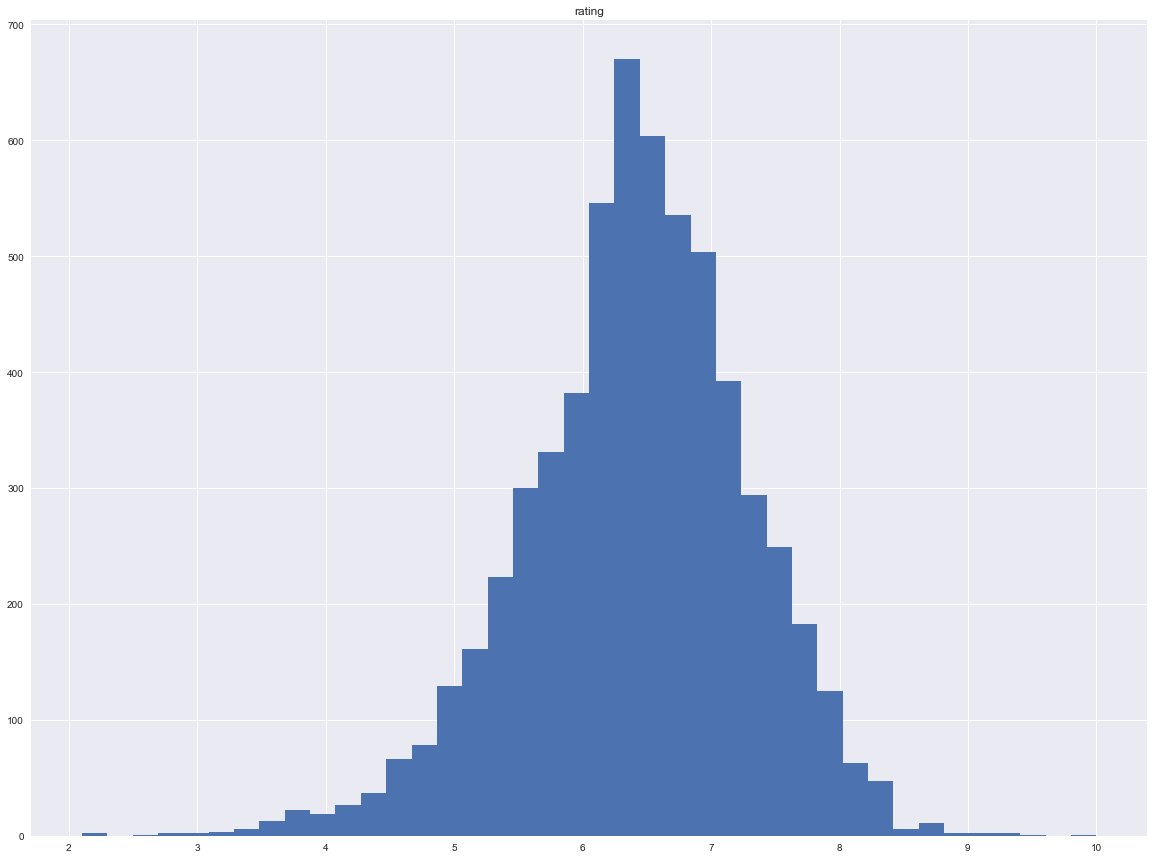

In [550]:
plt.figure(figsize = (20,15))
df.hist('rating', bins = 40, figsize = (20,15))



Ratings are a beautiful bell curve. I might only zero-mean it but don't need to really transform it. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a9e2ba8>]], dtype=object)

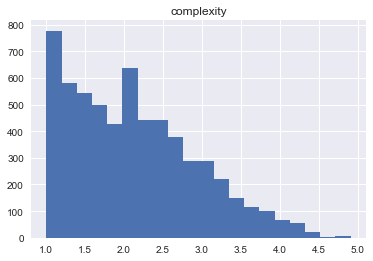

In [45]:
df.hist('complexity', bins = 20)

I'll do a log transformation on this to get normalize it

In [46]:
df.columns = [x.strip().replace ('_/', '') for x in df.columns]
df.columns = [x.strip().replace ('/', '_') for x in df.columns]
df.columns = [x.strip().replace ('-', '_') for x in df.columns]

In [54]:
rat = df['avg_time']
df= df.drop('avg_time', 1)
df.insert(0, 'avg_time', rat)


In [51]:
df.columns

Index(['rating', 'acting', 'action_movement_programming',
       'action_point_allowance_system', 'area_impulse',
       'area_control_area_influence', 'area_enclosure', 'area_movement',
       'auction_bidding', 'avg_time', 'betting_wagering',
       'campaign_battle_card_driven', 'card_drafting', 'chit_pull_system',
       'co_operative_play', 'commodity_speculation', 'complexity',
       'crayon_rail_system', 'deck_pool_building', 'dice_rolling', 'ebay',
       'grid_movement', 'hand_management', 'hex_and_counter', 'line_drawing',
       'mech_ct', 'memory', 'modular_board', 'paper_and_pencil',
       'partnerships', 'pattern_building', 'pattern_recognition',
       'pick_up_and_deliver', 'player_elimination', 'point_to_point_movement',
       'press_your_luck', 'retail', 'rock_paper_scissors', 'role_playing',
       'roll_spin_and_move', 'route_network_building',
       'secret_unit_deployment', 'set_collection', 'simulation',
       'simultaneous_action_selection', 'singing', 'sto

In [55]:
rat = df['ebay'] #need to turn this into a function
df= df.drop('ebay', 1)
df.insert(1, 'ebay', rat)

rat1 = df['retail']
df= df.drop('retail', 1)
df.insert(1, 'retail', rat1)

rat2 = df['mech_ct']
df= df.drop('mech_ct', 1)
df.insert(1, 'mech_ct', rat2)

rat3 = df['year']
df= df.drop('year', 1)
df.insert(1, 'year', rat3)

In [57]:
rat3 = df['rating']
df= df.drop('rating', 1)
df.insert(0, 'rating', rat3)

In [76]:
rat3 = df['complexity']
df= df.drop('complexity', 1)
df.insert(1, 'complexity', rat3)

In [60]:
df['year'] = df['year'].astype(int)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6049 entries, 0 to 4371
Data columns (total 59 columns):
rating                           6049 non-null float64
avg_time                         6049 non-null int64
year                             6049 non-null int64
mech_ct                          6049 non-null int64
retail                           1342 non-null float64
ebay                             2134 non-null float64
acting                           6049 non-null int64
action_movement_programming      6049 non-null int64
action_point_allowance_system    6049 non-null int64
area_impulse                     6049 non-null int64
area_control_area_influence      6049 non-null int64
area_enclosure                   6049 non-null int64
area_movement                    6049 non-null int64
auction_bidding                  6049 non-null int64
betting_wagering                 6049 non-null int64
campaign_battle_card_driven      6049 non-null int64
card_drafting                    6049 n

In [71]:
df = df.drop('title', 1)



In [77]:
df.to_pickle('games_v4')

In [60]:
df = pd.read_pickle('games_v4')

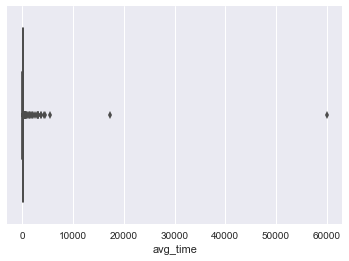

In [61]:
sns.boxplot(df['avg_time'])

Apparently there are some games that take 12 full days to play. Let's get rid of any outliers

In [62]:
df = df.drop(df[df['avg_time'] > 10000].index)

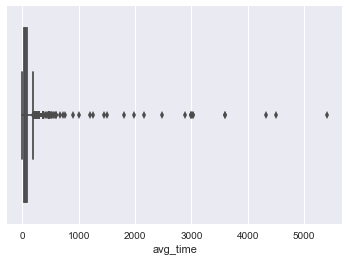

In [63]:
sns.boxplot(df['avg_time'])

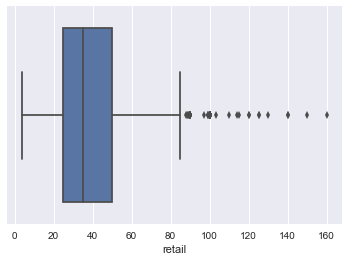

In [66]:
sns.boxplot(df['retail'])

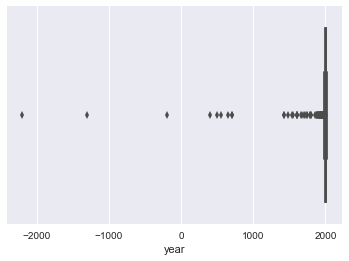

In [65]:
sns.boxplot(df['year'])

Boardgamegeeks includes games like Go and Chess, created centuries ago. Since I potentially want to use price as a feature, I'll get rid of these since I won't have any inflation data on any really old games

In [610]:
df = df.drop(df[df['year'] < 0].index)

In [146]:
#let's create and compare 2 datasets - one without price and one with price 
df_na = df.dropna(how = 'any')
df_pcls = df.drop(['retail', 'ebay'], 1)

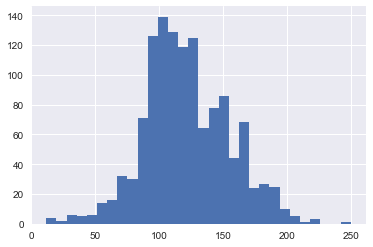

In [147]:
plt.hist(df_na.rating**2.5, bins = 30);

In [148]:
df_na = df_na.reset_index()

In [153]:
df_na.head()

,index,adj_rating,rating,complexity,avg_time,year,mech_ct,retail,ebay,acting,...,storytelling,take_that,tile_placement,time_track,trading,trick_taking,variable_phase_order,variable_player_powers,voting,worker_placement
0,51,70.942538,5.5,1.48,60,1937,1,22.00,6.99,0,...,0,0,0,0,0,0,0,0,0,0
1,82,67.761717,5.4,1.33,30,2014,3,24.99,19.95,0,...,0,0,0,0,0,0,0,1,0,0
2,114,77.568812,5.7,2.54,90,2008,4,49.99,127.89,0,...,0,0,0,0,0,0,0,0,0,0
3,121,64.668036,5.3,1.50,60,2008,4,19.99,14.52,0,...,0,0,0,0,1,0,0,0,0,0
4,139,67.761717,5.4,1.00,30,2013,1,10.95,7.99,0,...,0,1,0,0,0,0,0,0,0,0


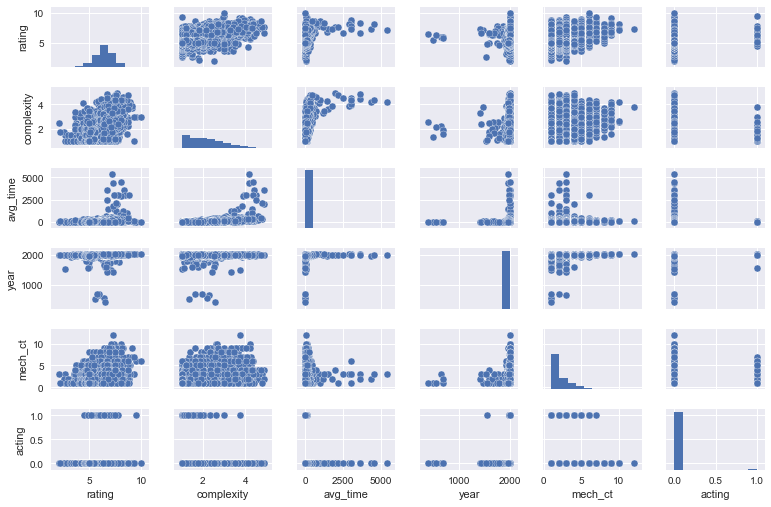

In [152]:
sns.pairplot(df_pcls.iloc[:, :6], size = 1.2, aspect = 1.5)

Without price as a feature

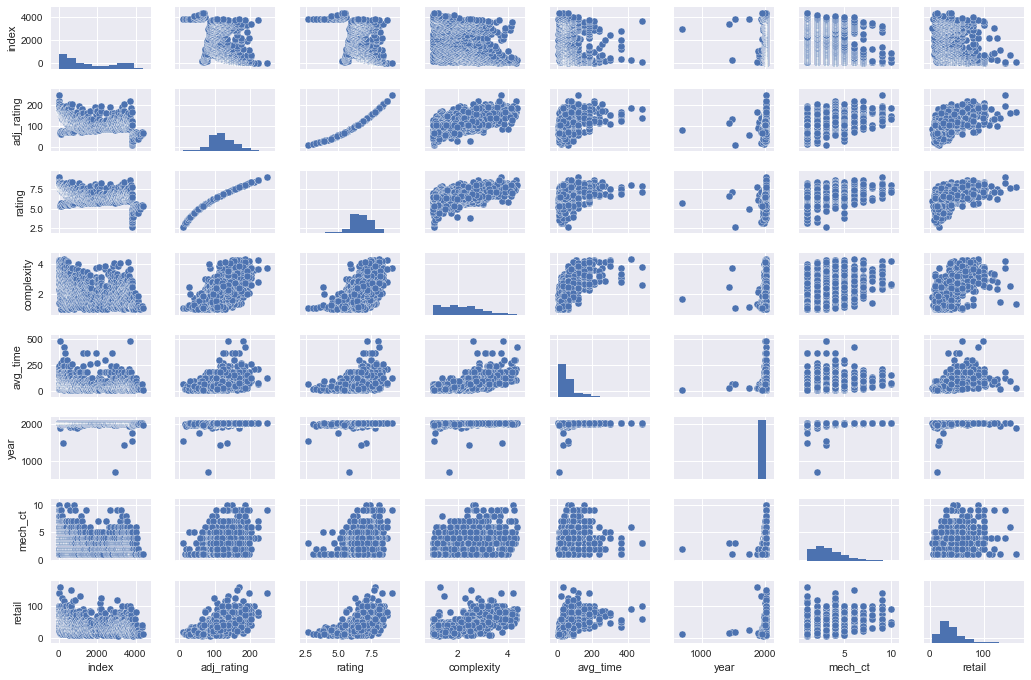

In [154]:
sns.pairplot(df_na.iloc[:, :8], size = 1.2, aspect = 1.5)

With price as a feature

In [580]:
df_na.corr()


,level_0,index,adj_rating,rating,complexity,avg_time,year,mech_ct,retail,ebay,...,storytelling,take_that,tile_placement,time_track,trading,trick_taking,variable_phase_order,variable_player_powers,voting,worker_placement
level_0,1.000000,0.945426,-0.479699,-0.470389,-0.345438,-0.169612,-0.127049,-0.230659,-0.282874,-0.050632,...,-0.047864,-0.017074,-0.063408,-0.007642,0.021239,0.028821,-0.099594,-0.127487,-0.032995,-0.174161
index,0.945426,1.000000,-0.508542,-0.511702,-0.333479,-0.159935,-0.141939,-0.238181,-0.272833,-0.060380,...,-0.037229,-0.030013,-0.079104,-0.013534,0.025145,0.025496,-0.093480,-0.129879,-0.029738,-0.164800
adj_rating,-0.479699,-0.508542,1.000000,0.989503,0.645106,0.358546,0.395933,0.381985,0.556048,0.071223,...,0.039675,-0.012076,0.076365,0.079310,-0.056364,-0.033905,0.163341,0.242320,0.000111,0.227883
rating,-0.470389,-0.511702,0.989503,1.000000,0.625040,0.340677,0.418643,0.372770,0.532714,0.070649,...,0.032699,-0.004467,0.081200,0.076132,-0.061287,-0.030957,0.154624,0.229789,0.003668,0.219548
complexity,-0.345438,-0.333479,0.645106,0.625040,1.000000,0.668759,0.189309,0.408834,0.681804,0.133116,...,-0.049091,-0.085362,0.101208,0.049647,0.047770,-0.088293,0.185721,0.270175,-0.049495,0.313056
avg_time,-0.169612,-0.159935,0.358546,0.340677,0.668759,1.000000,0.001634,0.286131,0.549513,0.125750,...,-0.008796,-0.062632,-0.010385,0.028995,0.095456,-0.060432,0.118766,0.163820,0.019625,0.114721
year,-0.127049,-0.141939,0.395933,0.418643,0.189309,0.001634,1.000000,0.198926,0.200939,-0.019628,...,0.044405,0.059293,0.002533,0.045410,-0.030731,-0.038526,0.033816,0.149832,-0.023083,0.144390
mech_ct,-0.230659,-0.238181,0.381985,0.372770,0.408834,0.286131,0.198926,1.000000,0.397437,0.050203,...,0.126687,0.104664,0.110645,0.114588,0.218594,-0.070410,0.171372,0.469454,0.090370,0.125346
retail,-0.282874,-0.272833,0.556048,0.532714,0.681804,0.549513,0.200939,0.397437,1.000000,0.159405,...,0.025125,-0.112361,0.078748,0.038041,0.004581,-0.130290,0.146751,0.268534,-0.043622,0.171933
ebay,-0.050632,-0.060380,0.071223,0.070649,0.133116,0.125750,-0.019628,0.050203,0.159405,1.000000,...,-0.001898,-0.030772,-0.005081,0.002302,-0.000023,-0.031910,0.006506,0.028778,-0.000668,0.011085


It looks like there might be a correlation between rating and price, so let's keep it in

In [114]:
df_pcls.corr()['rating'].sort_values(ascending = False)


rating                           1.000000
complexity                       0.540275
mech_ct                          0.300140
avg_time                         0.190389
hex_and_counter                  0.155563
variable_player_powers           0.155360
worker_placement                 0.153387
deck_pool_building               0.149292
dice_rolling                     0.146363
simulation                       0.140694
area_control_area_influence      0.138483
campaign_battle_card_driven      0.124449
action_point_allowance_system    0.115871
grid_movement                    0.113494
route_network_building           0.110270
co_operative_play                0.103695
chit_pull_system                 0.100715
card_drafting                    0.096972
variable_phase_order             0.093480
hand_management                  0.092367
year                             0.086751
modular_board                    0.079453
area_movement                    0.074421
action_movement_programming      0

In [116]:
df_na.to_pickle('games_no_na')

In [163]:

df_na[df_na['year'] < 1955]

,index,adj_rating,rating,complexity,avg_time,year,mech_ct,retail,ebay,acting,...,storytelling,take_that,tile_placement,time_track,trading,trick_taking,variable_phase_order,variable_player_powers,voting,worker_placement
0,51,70.942538,5.5,1.48,60,1937,1,22.00,6.99,0,...,0,0,0,0,0,0,0,0,0,0
119,64,169.916873,7.8,1.29,30,1876,1,159.99,199.99,0,...,0,0,0,0,0,0,0,0,0,0
248,246,134.321605,7.1,3.75,60,1475,1,17.99,15.30,0,...,0,0,0,0,0,0,0,0,0,0
457,596,103.621514,6.4,1.16,60,1903,2,13.31,9.98,0,...,0,0,0,0,1,0,0,0,0,0
483,636,99.621109,6.3,2.13,90,1948,2,16.99,14.00,0,...,0,0,1,0,0,0,0,0,0,0
544,795,120.579168,6.8,2.33,45,1904,2,7.99,2.65,0,...,0,0,0,0,0,1,0,0,0,0
606,976,91.901921,6.1,2.13,30,1883,2,13.99,24.99,0,...,0,0,1,0,0,0,0,0,0,0
629,1087,139.101317,7.2,1.43,20,1932,1,129.99,129.99,0,...,0,0,0,0,0,0,0,0,0,0
961,2951,81.015848,5.8,1.64,10,700,2,12.99,6.28,0,...,0,0,0,0,0,0,0,0,0,0
1074,3376,116.194884,6.7,2.43,30,1430,3,14.99,7.95,0,...,0,0,0,0,0,1,0,0,0,0


I gathered inflation numbers dating back to the 1950s, so will focus this analysis on games made after then, which is still 98% of the games

In [164]:
df_na = df_na.drop(df_na[df_na['year'] < 1955].index)

In [165]:
df_na.sample(10)

,index,adj_rating,rating,complexity,avg_time,year,mech_ct,retail,ebay,acting,...,storytelling,take_that,tile_placement,time_track,trading,trick_taking,variable_phase_order,variable_player_powers,voting,worker_placement
710,1389,99.621109,6.3,1.97,60,2005,4,19.95,92.51,0,...,0,0,0,0,0,0,0,1,0,0
741,1529,134.321605,7.1,2.40,10,2001,1,29.95,11.99,0,...,0,0,0,0,0,0,0,0,0,0
318,358,125.061239,6.9,2.34,60,2001,7,49.99,159.99,0,...,0,0,0,0,0,0,0,1,0,0
1237,3958,61.660687,5.2,2.04,90,2001,4,29.99,62.75,0,...,0,0,0,0,1,0,0,0,0,0
1210,3821,24.589871,3.6,1.07,10,1965,1,7.99,15.87,0,...,0,0,0,0,0,0,0,0,0,0
64,4,210.643137,8.5,3.58,210,2016,4,99.95,75.98,0,...,0,0,0,0,0,0,0,0,0,0
1086,3432,125.061239,6.9,2.35,30,2000,2,9.00,32.20,0,...,0,0,0,0,0,0,0,0,0,0
754,1601,95.714828,6.2,1.22,37,2014,6,19.90,15.93,0,...,1,0,0,0,0,0,0,0,0,0
292,311,154.046969,7.5,2.30,37,2014,4,19.99,14.59,0,...,0,1,0,0,0,0,0,1,0,0
338,391,134.321605,7.1,2.71,45,2015,5,59.99,40.14,0,...,0,0,0,0,0,0,0,1,0,1


In [166]:
#i should adjust retail for inflation, using 2017 as the standard

cpi = pd.read_csv('CPI.csv')

In [167]:
cpi['Multiplier'] = 0
cpi['Multiplier'] = cpi['Annual'].apply(lambda x: 244.773/x)
cpi = cpi.rename(columns = {'Year': 'year'})

In [168]:
df_na = df_na.reset_index()
df_na.head()

,level_0,index,adj_rating,rating,complexity,avg_time,year,mech_ct,retail,ebay,...,storytelling,take_that,tile_placement,time_track,trading,trick_taking,variable_phase_order,variable_player_powers,voting,worker_placement
0,1,82,67.761717,5.4,1.33,30,2014,3,24.99,19.95,...,0,0,0,0,0,0,0,1,0,0
1,2,114,77.568812,5.7,2.54,90,2008,4,49.99,127.89,...,0,0,0,0,0,0,0,0,0,0
2,3,121,64.668036,5.3,1.50,60,2008,4,19.99,14.52,...,0,0,0,0,1,0,0,0,0,0
3,4,139,67.761717,5.4,1.00,30,2013,1,10.95,7.99,...,0,1,0,0,0,0,0,0,0,0
4,5,140,64.668036,5.3,1.00,20,2013,1,34.99,6.60,...,0,0,0,0,0,0,0,0,0,0


In [169]:
df_na2 = df_na.merge(cpi, how = 'left')

In [171]:
df_na2= df_na2.drop(['level_0', 'index'], 1)

In [176]:
df_na2.head()

,index,adj_rating,rating,complexity,avg_time,year,mech_ct,retail,ebay,acting,...,tile_placement,time_track,trading,trick_taking,variable_phase_order,variable_player_powers,voting,worker_placement,Annual,Multiplier
0,0,67.761717,5.4,1.33,30,2014,3,24.99,19.95,0,...,0,0,0,0,0,1,0,0,236.736,1.033949
1,1,77.568812,5.7,2.54,90,2008,4,49.99,127.89,0,...,0,0,0,0,0,0,0,0,215.303,1.136877
2,2,64.668036,5.3,1.50,60,2008,4,19.99,14.52,0,...,0,0,1,0,0,0,0,0,215.303,1.136877
3,3,67.761717,5.4,1.00,30,2013,1,10.95,7.99,0,...,0,0,0,0,0,0,0,0,232.957,1.050722
4,4,64.668036,5.3,1.00,20,2013,1,34.99,6.60,0,...,0,0,0,0,0,0,0,0,232.957,1.050722


In [175]:
df_na2['inf_retail'] = df_na2['retail'].apply(lambda x: x*df_na2['Multiplier'])

ValueError: Wrong number of items passed 1244, placement implies 1

The error came when I reran the book - it transformed the data properly the first time

In [217]:
df_na2.head(20)

,index,rating,complexity,avg_time,year,mech_ct,retail,ebay,acting,action_movement_programming,...,time_track,trading,trick_taking,variable_phase_order,variable_player_powers,voting,worker_placement,inf_retail,Annual,Multiplier
0,82,5.4,1.33,30,2014,3,24.99,19.95,0,0,...,0,0,0,0,1,0,0,25.838391,236.736,1.033949
1,114,5.7,2.54,90,2008,4,49.99,127.89,0,0,...,0,0,0,0,0,0,0,51.687121,215.303,1.136877
2,121,5.3,1.50,60,2008,4,19.99,14.52,0,0,...,0,1,0,0,0,0,0,20.668645,215.303,1.136877
3,139,5.4,1.00,30,2013,1,10.95,7.99,0,0,...,0,0,0,0,0,0,0,11.321744,232.957,1.050722
4,140,5.3,1.00,20,2013,1,34.99,6.60,0,0,...,0,0,0,0,0,0,0,36.177883,232.957,1.050722
5,192,5.5,1.51,60,1997,2,25.00,37.99,0,0,...,0,0,0,0,0,0,0,25.848730,160.500,1.525065
6,203,5.6,1.63,45,2009,1,34.95,119.41,0,0,...,0,0,0,0,0,0,0,36.136525,214.537,1.140936
7,268,5.5,1.80,90,2003,1,29.99,55.00,0,0,...,0,0,0,0,0,0,0,31.008137,184.000,1.330288
8,269,5.5,1.39,30,2002,1,39.99,48.95,0,0,...,0,0,0,0,0,0,0,41.347629,179.900,1.360606
9,275,5.5,1.72,45,2003,1,19.95,24.95,0,1,...,0,0,0,0,0,0,0,20.627287,184.000,1.330288


In [218]:
df_na2 = df_na2.drop(['index', 'Annual', 'Multiplier'], 1)

In [246]:
df_na2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 1242
Data columns (total 59 columns):
rating                           1243 non-null float64
complexity                       1243 non-null float64
avg_time                         1243 non-null int64
year                             1243 non-null int64
mech_ct                          1243 non-null int64
retail                           1243 non-null float64
ebay                             1243 non-null float64
acting                           1243 non-null int64
action_movement_programming      1243 non-null int64
action_point_allowance_system    1243 non-null int64
area_impulse                     1243 non-null int64
area_control_area_influence      1243 non-null int64
area_enclosure                   1243 non-null int64
area_movement                    1243 non-null int64
auction_bidding                  1243 non-null int64
betting_wagering                 1243 non-null int64
campaign_battle_card_driven      1243

In [219]:
df_na2.to_pickle('games_v5')

In [177]:
df_na2 = pd.read_pickle('games_v5')

Binning the years so that it's categorical


In [255]:

bins = [1954, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2017]
group_names = ['1955-1960', '1960- 1965', '1965-1970', '1970-1975','1975-1980', '1980-1985', '1985-1990','1990-1995', '1995-2000', '2000-2005','2005-2010', '2010-2015', '2015-2017']
df_na2['yr_bin'] = pd.cut(df_na2['year'], bins, labels=group_names)


In [256]:
X=patsy.dmatrix('yr_bin',data=df_na2,return_type='dataframe')

df_na3 = df_na2.join(X)

In [377]:
X.columns

Index(['Intercept', 'yr_bin[T.1960- 1965]', 'yr_bin[T.1965-1970]',
       'yr_bin[T.1970-1975]', 'yr_bin[T.1975-1980]', 'yr_bin[T.1980-1985]',
       'yr_bin[T.1985-1990]', 'yr_bin[T.1990-1995]', 'yr_bin[T.1995-2000]',
       'yr_bin[T.2000-2005]', 'yr_bin[T.2005-2010]', 'yr_bin[T.2010-2015]',
       'yr_bin[T.2015-2017]'],
      dtype='object')

In [ ]:
df_na3 = df_na2.join(X)

In [257]:
df_na3.to_pickle('binnedandadjusted')

In [258]:
df_na3[df_na3.yr_bin.isnull() == True]

,rating,adj_rating,complexity,avg_time,year,mech_ct,retail,ebay,acting,action_movement_programming,...,yr_bin[T.1970-1975],yr_bin[T.1975-1980],yr_bin[T.1980-1985],yr_bin[T.1985-1990],yr_bin[T.1990-1995],yr_bin[T.1995-2000],yr_bin[T.2000-2005],yr_bin[T.2005-2010],yr_bin[T.2010-2015],yr_bin[T.2015-2017]


### Analysis ###

Let's first normalize the features 

In [304]:
df_3 = df_na3.drop(['adj_rating', 'rating', 'retail', 'year', 'yr_bin'], 1)
Xnorm, norm = preprocessing.normalize(df_3, return_norm=True, axis = 0)
y = df_na3['rating']

In [305]:
X_trans = pd.DataFrame(Xnorm, columns = df_3.columns)

In [306]:
X_trans.head()

,complexity,avg_time,mech_ct,ebay,acting,action_movement_programming,action_point_allowance_system,area_impulse,area_control_area_influence,area_enclosure,...,yr_bin[T.1970-1975],yr_bin[T.1975-1980],yr_bin[T.1980-1985],yr_bin[T.1985-1990],yr_bin[T.1990-1995],yr_bin[T.1995-2000],yr_bin[T.2000-2005],yr_bin[T.2005-2010],yr_bin[T.2010-2015],yr_bin[T.2015-2017]
0,0.016393,0.010496,0.024171,0.003756,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043519,0.0
1,0.031307,0.031489,0.032228,0.024079,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061898,0.000000,0.0
2,0.018488,0.020993,0.032228,0.002734,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061898,0.000000,0.0
3,0.012325,0.010496,0.008057,0.001504,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043519,0.0
4,0.012325,0.006998,0.008057,0.001243,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043519,0.0


In [307]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size = .2)

In [308]:
est = sm.OLS(y_train, X_train)

fit = est.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     19.96
Date:                Thu, 13 Jul 2017   Prob (F-statistic):          5.20e-138
Time:                        08:58:21   Log-Likelihood:                -706.58
No. Observations:                 994   AIC:                             1551.
Df Residuals:                     925   BIC:                             1889.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
complexity                       40.4722      3.351     12.076      0.000        33.895    47.049
avg_time                         -6.3344      1.599     -3.962      0.000        -9.472    -3.197
mech_ct                         -18.6901     11.140     -1.678      0.094       -40.553     3.173
ebay                              0.0397      0.572      0.069      0.945        -1.083     1.162
acting                            0.9711      0.730      1.330      0.184        -0.462     2.404
action_movement_programming       1.0959      0.835      1.312      0.190        -0.543     2.735
action_point_allowance_system     2.6742      1.156      2.314      0.021         0.406     4.942
area_impulse                      0.5348      0.680      0.787      0.432        -0.800     1.869
area_control_area_influence       1.8779      1.246      1.507      0.132        -0.568     4.323
area_enclosure                   -0.1363      0.728     -0.187      0.852        -1.566     1.293
area_movement                     1.8854      1.105      1.707      0.088        -0.283     4.054
auction_bidding                   1.2700      1.071      1.185      0.236        -0.833     3.373
betting_wagering                  2.1378      0.692      3.088      0.002         0.779     3.496
campaign_battle_card_driven       2.2941      0.920      2.494      0.013         0.489     4.100
card_drafting                     2.8952      1.333      2.172      0.030         0.280     5.511
chit_pull_system                  0.4447      0.663      0.670      0.503        -0.857     1.747
co_operative_play                 2.0298      1.121      1.810      0.071        -0.171     4.230
commodity_speculation             0.2354      0.726      0.324      0.746        -1.189     1.660
crayon_rail_system                1.0225      0.680      1.504      0.133        -0.312     2.357
deck_pool_building                3.4185      0.974      3.509      0.000         1.506     5.331
dice_rolling                      3.6755      1.702      2.160      0.031         0.336     7.015
grid_movement                     3.3853      1.054      3.213      0.001         1.318     5.453
hand_management                   4.8790      1.806      2.701      0.007         1.334     8.424
hex_and_counter                   1.8565      0.806      2.304      0.021         0.275     3.438
line_drawing                      2.0552      0.688      2.988      0.003         0.705     3.405
memory                            0.8064      0.884      0.912      0.362        -0.929     2.542
modular_board                    -0.4726      1.284     -0.368      0.713        -2.992     2.047
paper_and_pencil                  0.9636      0.701      1.374      0.170        -0.412     2.340
partnerships                      1.4017     

In [309]:
est1 = LinearRegression()

est1.fit(X_train, y_train)
est1.score(X_test, y_test)


0.45372060684919802

Alright let's drop features with high p-values 

In [313]:
X1_trans = X_trans.drop(['ebay', 'area_impulse', 'area_enclosure', 'chit_pull_system', 'commodity_speculation',
                        'modular_board', 'rock_paper_scissors', 'roll_spin_and_move', 'secret_unit_deployment',
                        'singing',], 1)

In [314]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_trans, y, test_size = .2)

est = sm.OLS(y1_train, X1_train)

fit = est.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     21.79
Date:                Thu, 13 Jul 2017   Prob (F-statistic):          2.01e-135
Time:                        09:02:18   Log-Likelihood:                -724.53
No. Observations:                 994   AIC:                             1567.
Df Residuals:                     935   BIC:                             1856.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
complexity                       37.6185      3.205     11.738      0.000        31.329    43.908
avg_time                         -2.7590      1.380     -2.000      0.046        -5.467    -0.051
mech_ct                         -12.1440      4.641     -2.617      0.009       -21.252    -3.036
acting                            0.7226      0.672      1.075      0.282        -0.596     2.041
action_movement_programming       0.1365      0.667      0.205      0.838        -1.172     1.445
action_point_allowance_system     1.7819      0.798      2.233      0.026         0.216     3.348
area_control_area_influence       1.5966      0.790      2.021      0.044         0.046     3.147
area_movement                     0.3523      0.792      0.445      0.657        -1.202     1.907
auction_bidding                   0.5582      0.731      0.763      0.446        -0.877     1.993
betting_wagering                  1.4906      0.599      2.488      0.013         0.315     2.667
campaign_battle_card_driven       1.6866      0.674      2.501      0.013         0.363     3.010
card_drafting                     2.3095      0.809      2.854      0.004         0.722     3.897
co_operative_play                 1.6999      0.772      2.203      0.028         0.186     3.214
crayon_rail_system                0.9329      0.624      1.495      0.135        -0.292     2.158
deck_pool_building                2.6126      0.699      3.736      0.000         1.240     3.985
dice_rolling                      2.3427      1.045      2.242      0.025         0.292     4.393
grid_movement                     3.1596      0.791      3.994      0.000         1.607     4.712
hand_management                   3.1276      1.019      3.071      0.002         1.129     5.127
hex_and_counter                   1.7666      0.706      2.502      0.013         0.381     3.152
line_drawing                      1.7081      0.676      2.526      0.012         0.381     3.035
memory                            0.6849      0.695      0.986      0.324        -0.678     2.048
paper_and_pencil                  0.3405      0.686      0.496      0.620        -1.006     1.687
partnerships                      0.1367      0.782      0.175      0.861        -1.398     1.672
pattern_building                  0.6786      0.675      1.006      0.315        -0.645     2.003
pattern_recognition               0.8127      0.650      1.250      0.212        -0.463     2.088
pick_up_and_deliver               0.2643      0.768      0.344      0.731        -1.242     1.771
player_elimination                1.2567      0.666      1.886      0.060        -0.051     2.564
point_to_point_movement           1.7304      0.728      2.377      0.018         0.302     3.159
press_your_luck                   0.9971     

In [316]:
est1 = LinearRegression()
est1.fit(X1_train, y1_train)
est1.score(X1_test, y1_test)

0.52953078783386553

In [317]:
est1.score(X1_train, y1_train)

0.57477910745052274

In [319]:
X2_trans = X1_trans.drop(['action_movement_programming', 'area_movement',  'paper_and_pencil',
                         'partnerships', 'pick_up_and_deliver', 'yr_bin[T.1970-1975]'], 1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_trans, y, test_size = .2)

est2 = LinearRegression()

est2.fit(X2_train, y2_train)
print(est2.score(X2_train, y2_train))
print(est2.score(X2_test, y2_test))

0.565954909945
0.533752068959


In [320]:
est = sm.OLS(y2_train, X2_train)

fit = est.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     23.60
Date:                Thu, 13 Jul 2017   Prob (F-statistic):          1.64e-135
Time:                        09:05:45   Log-Likelihood:                -747.33
No. Observations:                 994   AIC:                             1601.
Df Residuals:                     941   BIC:                             1860.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
complexity                       39.7626      3.302     12.042      0.000        33.282    46.243
avg_time                         -4.9521      1.425     -3.475      0.001        -7.749    -2.155
mech_ct                         -11.5681      3.314     -3.491      0.001       -18.071    -5.065
acting                            1.0622      0.612      1.737      0.083        -0.138     2.263
action_point_allowance_system     1.4030      0.763      1.838      0.066        -0.095     2.901
area_control_area_influence       2.7071      0.757      3.577      0.000         1.222     4.192
auction_bidding                   0.3139      0.709      0.443      0.658        -1.077     1.704
betting_wagering                  1.2128      0.602      2.014      0.044         0.031     2.395
campaign_battle_card_driven       1.5800      0.642      2.463      0.014         0.321     2.839
card_drafting                     2.4974      0.767      3.257      0.001         0.992     4.002
co_operative_play                 2.5613      0.768      3.334      0.001         1.054     4.069
crayon_rail_system                1.0501      0.640      1.640      0.101        -0.206     2.307
deck_pool_building                1.8734      0.703      2.665      0.008         0.494     3.253
dice_rolling                      2.3447      0.948      2.474      0.014         0.485     4.205
grid_movement                     3.7072      0.745      4.975      0.000         2.245     5.170
hand_management                   3.8768      0.875      4.431      0.000         2.160     5.594
hex_and_counter                   2.3825      0.716      3.329      0.001         0.978     3.787
line_drawing                      2.0040      0.562      3.567      0.000         0.901     3.107
memory                            0.4265      0.646      0.660      0.509        -0.841     1.694
pattern_building                  0.6859      0.673      1.020      0.308        -0.634     2.006
pattern_recognition               1.0652      0.581      1.833      0.067        -0.075     2.206
player_elimination                1.9511      0.716      2.725      0.007         0.546     3.356
point_to_point_movement           1.9032      0.679      2.805      0.005         0.572     3.235
press_your_luck                   1.5785      0.661      2.388      0.017         0.281     2.876
role_playing                      0.8287      0.673      1.231      0.219        -0.493     2.150
route_network_building            1.5270      0.667      2.290      0.022         0.218     2.836
set_collection                    2.8658      0.794      3.611      0.000         1.308     4.423
simulation                        1.2893      0.652      1.977      0.048         0.009     2.569
simultaneous_action_selection     1.7984     

In [322]:
X3_trans = X2_trans.drop(['auction_bidding', 'memory', 'yr_bin[T.1975-1980]', 'yr_bin[T.1980-1985]'], 1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_trans, y, test_size = .2)

est3 = LinearRegression()

est3.fit(X3_trans, y)
print(est3.score(X3_train, y3_train))
print(est3.score(X3_test, y3_test))



0.561437876098
0.593821669474


In [323]:
est = sm.OLS(y3_train, X3_train)

fit = est.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     25.67
Date:                Thu, 13 Jul 2017   Prob (F-statistic):          2.52e-138
Time:                        09:07:38   Log-Likelihood:                -763.86
No. Observations:                 994   AIC:                             1626.
Df Residuals:                     945   BIC:                             1866.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
complexity                       39.0779      3.337     11.710      0.000        32.529    45.627
avg_time                         -3.4886      1.506     -2.316      0.021        -6.445    -0.533
mech_ct                         -10.3651      2.913     -3.558      0.000       -16.083    -4.648
acting                            1.5359      0.647      2.373      0.018         0.265     2.806
action_point_allowance_system     1.4431      0.740      1.949      0.052        -0.010     2.896
area_control_area_influence       1.3410      0.723      1.855      0.064        -0.078     2.760
betting_wagering                  1.6393      0.588      2.787      0.005         0.485     2.794
campaign_battle_card_driven       1.6426      0.693      2.369      0.018         0.282     3.004
card_drafting                     2.3154      0.756      3.061      0.002         0.831     3.800
co_operative_play                 1.2492      0.734      1.702      0.089        -0.191     2.690
crayon_rail_system                0.7814      0.602      1.297      0.195        -0.401     1.963
deck_pool_building                2.3654      0.673      3.517      0.000         1.045     3.685
dice_rolling                      1.5622      0.902      1.731      0.084        -0.209     3.333
grid_movement                     2.4264      0.706      3.439      0.001         1.042     3.811
hand_management                   3.5330      0.872      4.049      0.000         1.821     5.245
hex_and_counter                   1.7289      0.669      2.583      0.010         0.415     3.043
line_drawing                      2.4928      0.618      4.033      0.000         1.280     3.706
pattern_building                  1.0820      0.642      1.686      0.092        -0.177     2.341
pattern_recognition               1.8023      0.618      2.915      0.004         0.589     3.016
player_elimination                0.9341      0.679      1.375      0.169        -0.399     2.267
point_to_point_movement           1.1408      0.688      1.659      0.098        -0.209     2.491
press_your_luck                   1.6600      0.728      2.280      0.023         0.231     3.089
role_playing                      1.1451      0.691      1.656      0.098        -0.212     2.502
route_network_building            1.8557      0.710      2.614      0.009         0.462     3.249
set_collection                    3.1335      0.781      4.013      0.000         1.601     4.666
simulation                        1.4211      0.705      2.016      0.044         0.037     2.805
simultaneous_action_selection     1.7483      0.715      2.445      0.015         0.345     3.151
stock_holding                     0.8074      0.652      1.238      0.216        -0.473     2.088
storytelling                      1.5190     

In [504]:
est = LinearRegression()
from sklearn import feature_selection as f_select

kf = KFold(n = len(X3_trans), n_folds = 10, shuffle = True)

all_scores = []

for train, test in kf:
    x_train = X3_trans.iloc[train]
    y_train = y.iloc[train]
    x_test = X3_trans.iloc[test]
    y_test = y.iloc[test]
    pvals = []
    sig_cols = []
    
    for feature in x_train.columns:
        pval = f_select.f_regression(x_train[[feature]], y_train)
        if pval[1][0] <.02:
            sig_cols.append(feature)
            pvals.append(pval[1][0])
    est.fit(x_train[sig_cols], y_train)
    r_2 = est.score(x_test[sig_cols], y_test)
    all_scores.append(r_2)
    
np.mean(all_scores)

0.50640140524229971

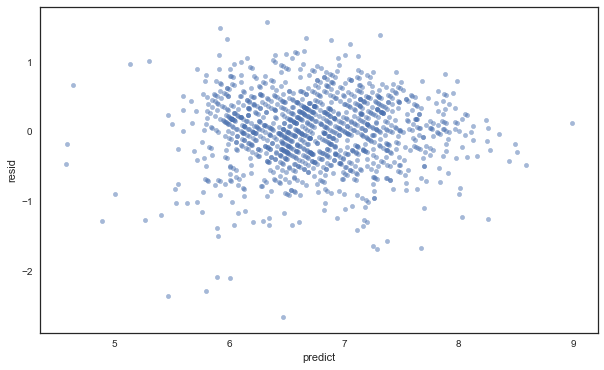

In [326]:
X3_trans['predict']=est3.predict(X3_trans)
X3_trans['resid']= y-X3_trans.predict
with sns.axes_style('white'):
    plot = X3_trans.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

It looks like the predicted variable is centralized around 0 (good) and decently spread out, although clustered around ratings 6-8.

Let's try regularizing the data

In [499]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso

rcv = RidgeCV(cv = 10)
rcv.fit(X3_trans, y)
rcv.score(X3_test, y3_test)



0.54614068972614849

In [531]:
from sklearn.linear_model import LassoCV

lcv = LassoCV(cv = 10)
lcv.fit(X3_trans, y)
lcv.score(X3_test, y3_test)


0.59434047962283199

In [518]:
lcv.coef_

array([ 38.77354863,  -3.63368913,  -8.26213952,   0.71870392,
         1.41993778,   1.50909271,   1.58774322,   1.5667808 ,
         1.93944957,   1.49387978,   0.81925188,   2.20679263,
         1.41219468,   2.66173569,   2.86322623,   1.63035617,
         1.90080444,   0.69853007,   0.98911327,   1.0491162 ,
         1.12301998,   1.17748277,   0.71582581,   1.47215255,
         2.73585629,   1.22078001,   1.66857964,   0.68826073,
         1.04374837,   1.15450354,   1.45709711,   0.8127429 ,
        -1.5207662 ,   1.50173889,   1.59038709,   1.31566071,
         1.75494095,   1.23016323,  10.44104437,  -0.        ,
        -1.30456519,  -1.64375949,   1.09317285,   1.93129972,
         2.80023388,   3.40971985,   5.92813308,  12.80746218,  10.69559823])

In [503]:
from sklearn.linear_model import ElasticNetCV

ecv = ElasticNetCV(cv = 10)
ecv.fit(X3_trans, y)
ecv.score(X3_test, y3_test)


0.59279064862636877

((array([-3.25978419, -2.99925967, -2.85417294, ...,  2.85417294,
          2.99925967,  3.25978419]),
  array([-2.67123917, -2.36850392, -2.29457519, ...,  1.3843126 ,
          1.48314308,  1.56730642])),
 (0.5074427466468735, 8.9277222951015732e-16, 0.98931712482090828))

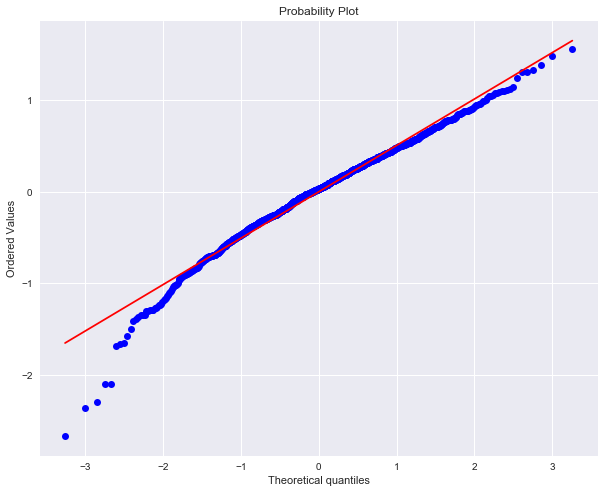

In [364]:
import scipy.stats as stats

plt.figure(figsize = (10,8))
stats.probplot(X3_trans['resid'], dist="norm", plot=plt)


Ahh it's good at predicting middling games, but bad at predicting really bad games. Maybe there's something thematic about a bad game? I should look into the really bad games and see if it's missing any data that I'm not picking up on

In [99]:
df_3.corr().to_excel('corr.xls') 
# exported to xls to see if there's any issue with multicollinearity; doesn't look like it

In [517]:
estL=Lasso(alpha=5.6467401075090316e-06,fit_intercept=True)
estL.fit(X3_trans,y)
estL.score(X3_trans,y)

0.56697696382100793

In [ ]:
estL.fit(X3_tran, y)

estL.score(X3_t)

In [519]:
zipped = zip(X3_trans.columns, lcv.coef_)
features = sorted(zipped, key = lambda x: x[1], reverse = True)

In [520]:
features[:10]

[('complexity', 38.773548633910281),
 ('yr_bin[T.2010-2015]', 12.807462177687354),
 ('yr_bin[T.2015-2017]', 10.695598233388518),
 ('inf_retail', 10.441044368183224),
 ('yr_bin[T.2005-2010]', 5.9281330788779405),
 ('yr_bin[T.2000-2005]', 3.409719849087149),
 ('hand_management', 2.8632262349227267),
 ('yr_bin[T.1995-2000]', 2.8002338788161225),
 ('set_collection', 2.7358562859789055),
 ('grid_movement', 2.6617356928271847)]

In [521]:
features[39:]

[('acting', 0.71870391720666493),
 ('role_playing', 0.71582580859055223),
 ('pattern_building', 0.69853007417216428),
 ('stock_holding', 0.68826073095193629),
 ('Intercept', -0.0),
 ('yr_bin[T.1960- 1965]', -1.3045651923775892),
 ('trading', -1.5207662003757789),
 ('yr_bin[T.1965-1970]', -1.6437594873312742),
 ('avg_time', -3.6336891259448363),
 ('mech_ct', -8.2621395203846149)]

Looks like complexity of the game, those made most recently (possibly due to a recency bias?), and cost adjusted for inflation are the biggest indicators for a game rating

In [389]:
X3_trans = X3_trans.drop(['predict', 'resid'], 1)

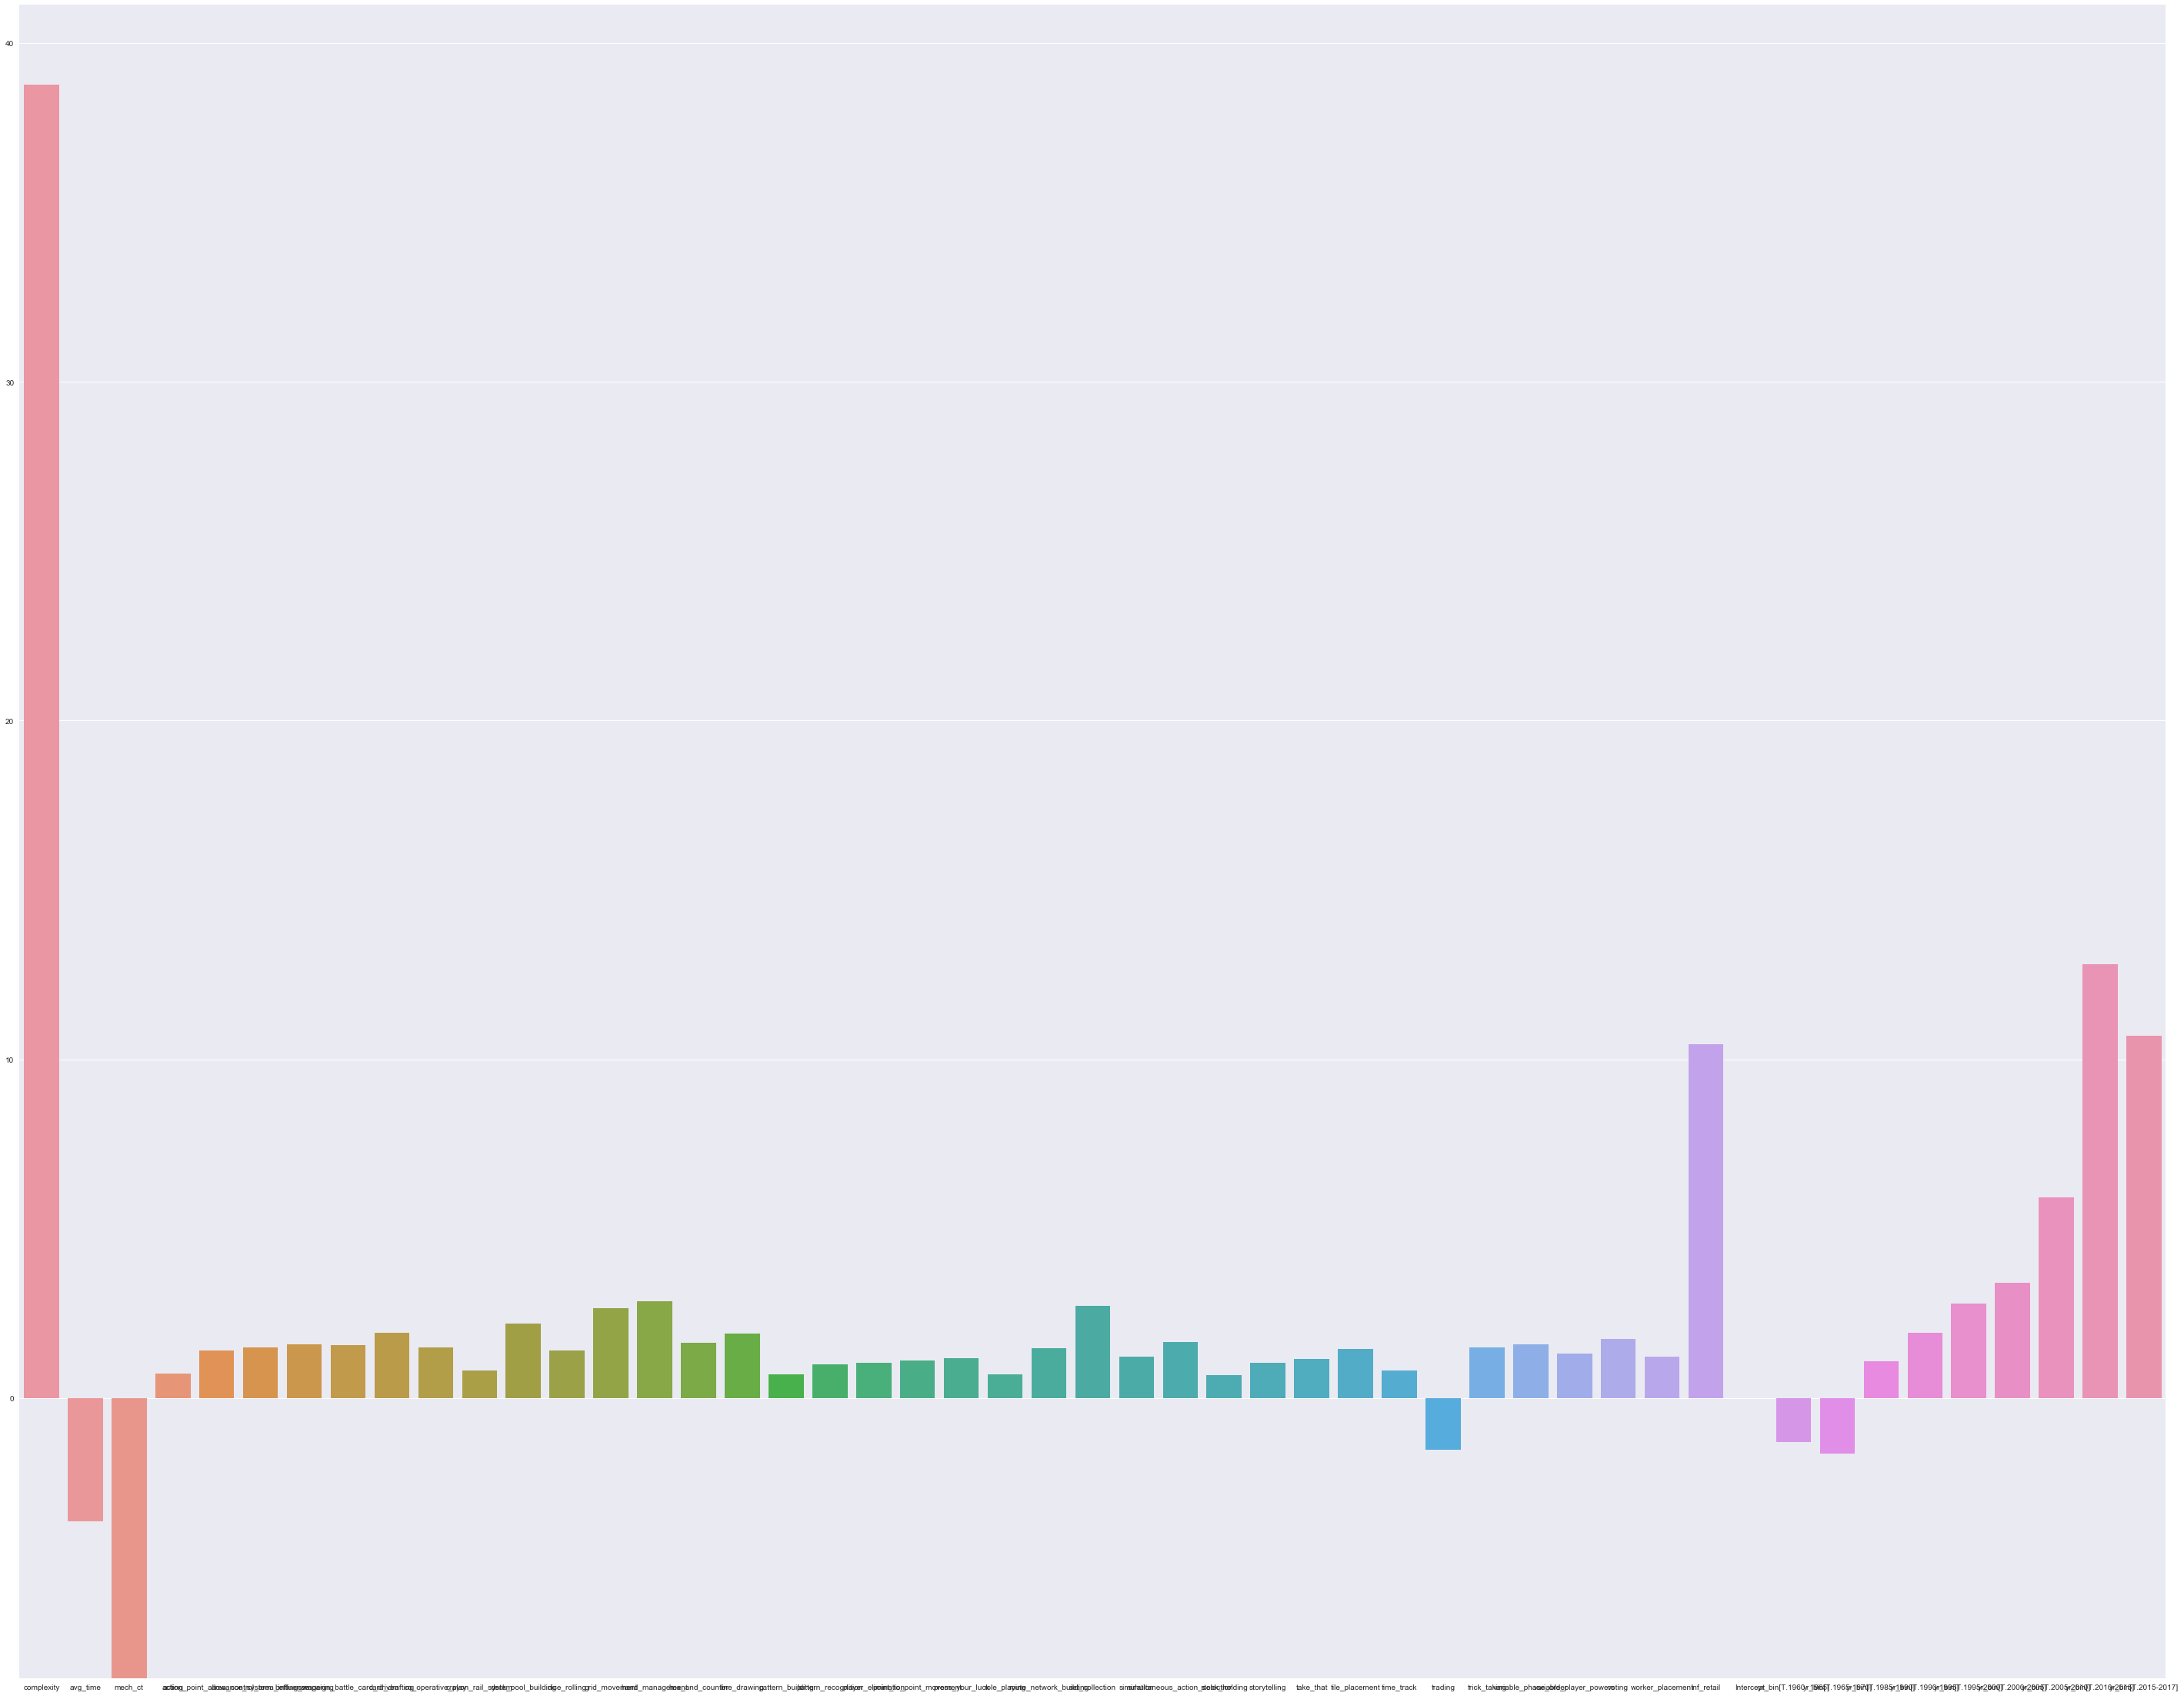

In [522]:
plt.figure(figsize = (50,40))
ax = sns.barplot(X3_trans.columns, estL.coef_)


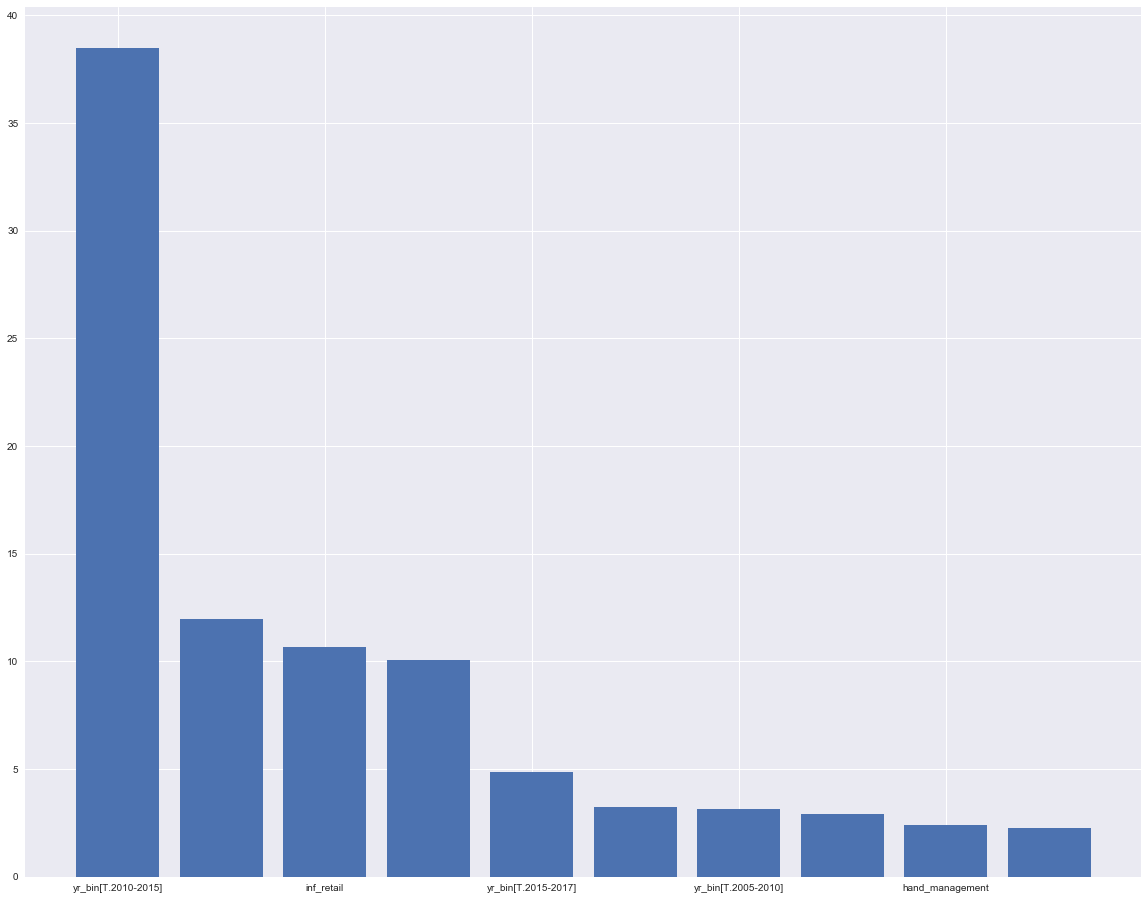

In [443]:
x_val = [x[0] for x in features]
y_val = [x[1] for x in features]

fig, ax = plt.subplots(figsize = (20,16))
ax.bar(range(10),y_val[0:10])
ax.set_xticklabels(x_val[0:10])

['complexity',
 'yr_bin[T.2010-2015]',
 'inf_retail',
 'yr_bin[T.2015-2017]',
 'yr_bin[T.2005-2010]',
 'hand_management',
 'yr_bin[T.2000-2005]',
 'set_collection',
 'line_drawing',
 'deck_pool_building',
 'yr_bin[T.1995-2000]',
 'grid_movement',
 'card_drafting',
 'variable_phase_order',
 'voting',
 'route_network_building',
 'pattern_recognition',
 'variable_player_powers',
 'hex_and_counter',
 'worker_placement',
 'betting_wagering',
 'simultaneous_action_selection',
 'campaign_battle_card_driven',
 'press_your_luck',
 'storytelling',
 'trick_taking',
 'acting',
 'yr_bin[T.1990-1995]',
 'simulation',
 'action_point_allowance_system',
 'dice_rolling',
 'area_control_area_influence',
 'tile_placement',
 'co_operative_play',
 'take_that',
 'point_to_point_movement',
 'role_playing',
 'pattern_building',
 'time_track',
 'player_elimination',
 'stock_holding',
 'crayon_rail_system',
 'yr_bin[T.1985-1990]',
 'Intercept',
 'yr_bin[T.1960- 1965]',
 'yr_bin[T.1965-1970]',
 'trading',
 'avg_t

I should've plotted out the years earlier. Let's do that now since it's such an important feature 

/Users/leangchaing/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


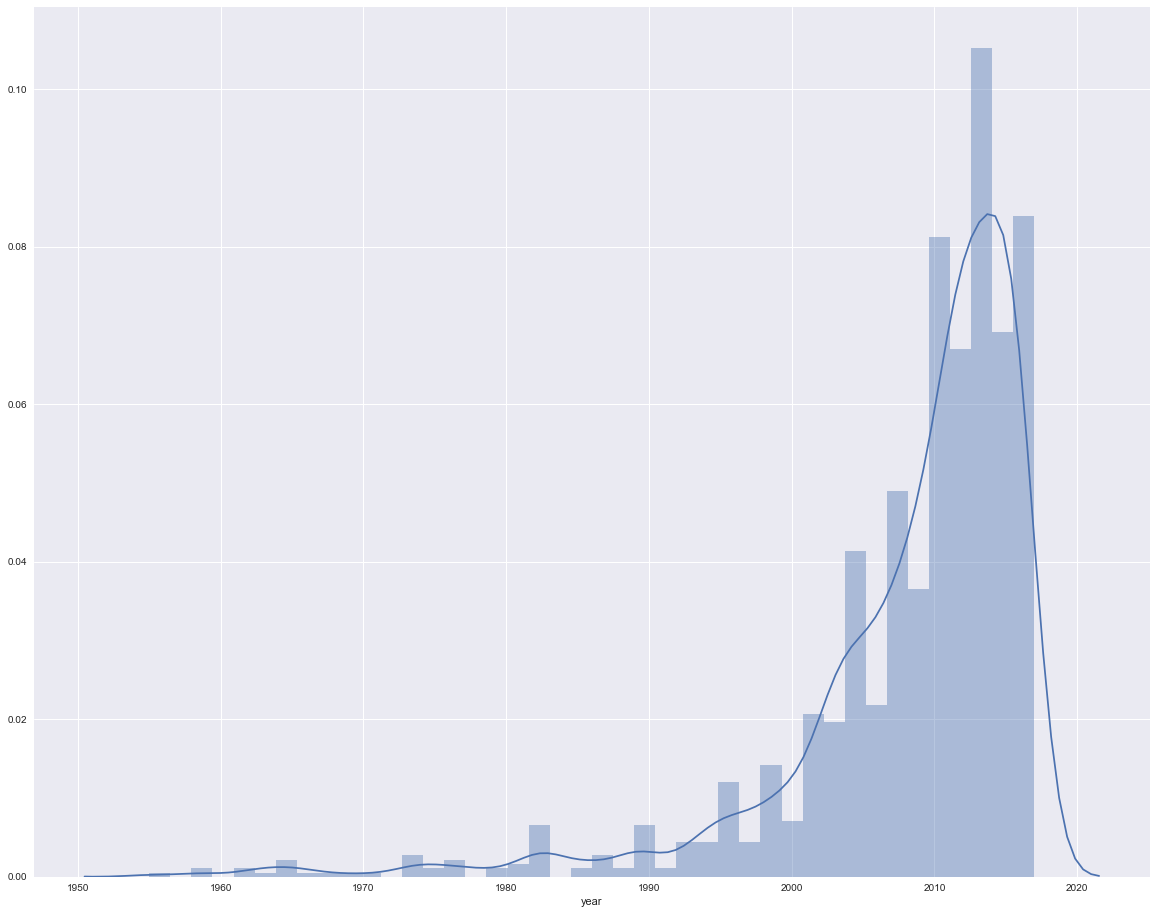

In [466]:
plt.figure(figsize = (20,16))
sns.distplot(df_na3['year'])

Wow look at that left tail! A majority of games analyzed have been made in the last 15 years

In [536]:
q1 = df_na3['rating'].quantile(.25)
q3 = df_na3['rating'].quantile(.75)

df_btm = df_na3[df_na3['rating'] <= q1]
df_top = df_na3[df_na3['rating'] >= q3]

In [539]:
df_na3.describe()

,rating,adj_rating,complexity,avg_time,year,mech_ct,retail,ebay,acting,action_movement_programming,...,yr_bin[T.1970-1975],yr_bin[T.1975-1980],yr_bin[T.1980-1985],yr_bin[T.1985-1990],yr_bin[T.1990-1995],yr_bin[T.1995-2000],yr_bin[T.2000-2005],yr_bin[T.2005-2010],yr_bin[T.2010-2015],yr_bin[T.2015-2017]
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,...,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000
mean,6.753419,121.527196,2.170539,61.053902,2008.410298,3.062751,39.366138,51.854642,0.011263,0.032180,...,0.006436,0.004827,0.013677,0.015286,0.022526,0.047466,0.120676,0.209976,0.424779,0.123894
std,0.778016,33.423701,0.764818,53.352589,8.994217,1.736486,21.556552,141.499810,0.105571,0.176549,...,0.079999,0.069337,0.116191,0.122736,0.148447,0.212719,0.325881,0.407455,0.494508,0.329593
min,3.100000,16.920151,1.000000,2.000000,1955.000000,1.000000,3.990000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.300000,99.621109,1.530000,30.000000,2006.000000,2.000000,24.950000,17.995000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.700000,116.194884,2.090000,45.000000,2011.000000,3.000000,34.990000,30.380000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.300000,143.981651,2.670000,75.000000,2014.000000,4.000000,49.990000,53.600000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,9.100000,249.806354,4.350000,480.000000,2017.000000,10.000000,150.000000,4284.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/Users/leangchaing/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


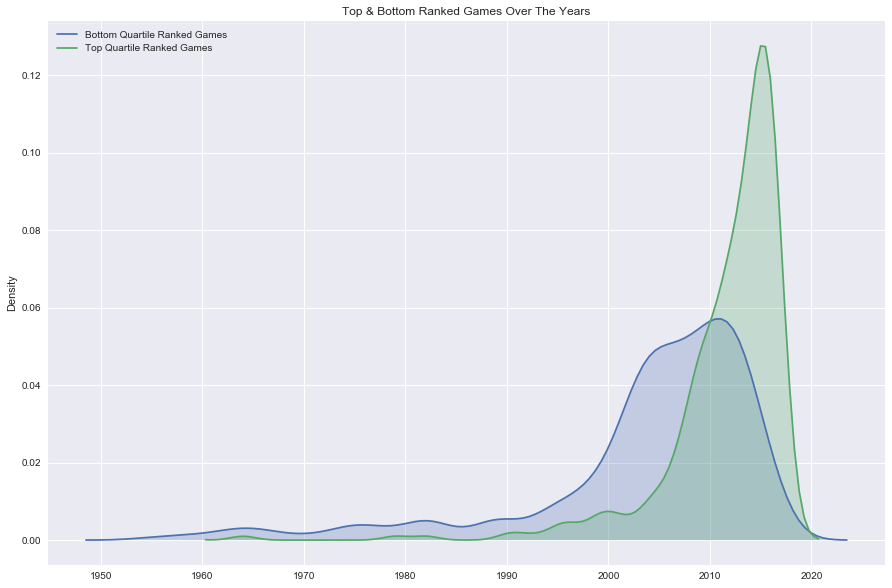

In [538]:
fig, ax = plt.subplots(figsize = (15,10))
sns.kdeplot(df_btm['year'], shade = True, label = 'Bottom Quartile Ranked Games')
sns.kdeplot(df_top['year'], shade = True, label = 'Top Quartile Ranked Games')
plt.legend()
plt.title('Top & Bottom Ranked Games Over The Years')
plt.ylabel('Density')

And it looks like most of the top games came from the last decade. We see most of the bottom ranked produced in the last 20 years too, but we really are living in the golden age of boardgames

In [529]:
X_trans.head()


,complexity,avg_time,mech_ct,ebay,acting,action_movement_programming,action_point_allowance_system,area_impulse,area_control_area_influence,area_enclosure,...,yr_bin[T.1970-1975],yr_bin[T.1975-1980],yr_bin[T.1980-1985],yr_bin[T.1985-1990],yr_bin[T.1990-1995],yr_bin[T.1995-2000],yr_bin[T.2000-2005],yr_bin[T.2005-2010],yr_bin[T.2010-2015],yr_bin[T.2015-2017]
0,0.016393,0.010496,0.024171,0.003756,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043519,0.0
1,0.031307,0.031489,0.032228,0.024079,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061898,0.000000,0.0
2,0.018488,0.020993,0.032228,0.002734,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061898,0.000000,0.0
3,0.012325,0.010496,0.008057,0.001504,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043519,0.0
4,0.012325,0.006998,0.008057,0.001243,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043519,0.0


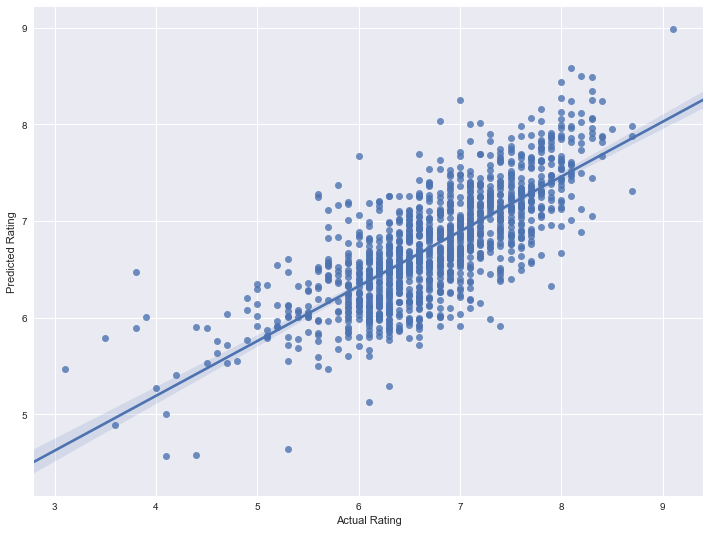

In [572]:
#predict = 
plt.figure(figsize = (12,9))
sns.regplot(y, est3.predict(X3_trans), scatter = True)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

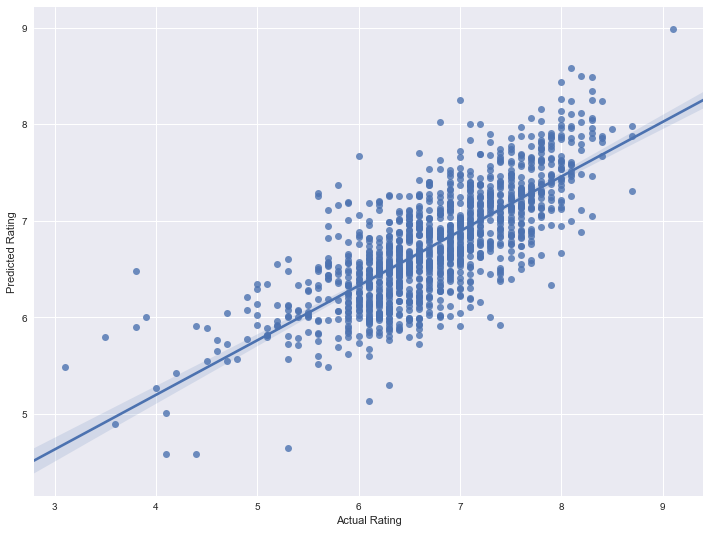

In [578]:
plt.figure(figsize = (12,9))

sns.regplot(y, lcv.predict(X3_trans), scatter = True)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

Yeah we see again that predictive variance for the tails of that data. 

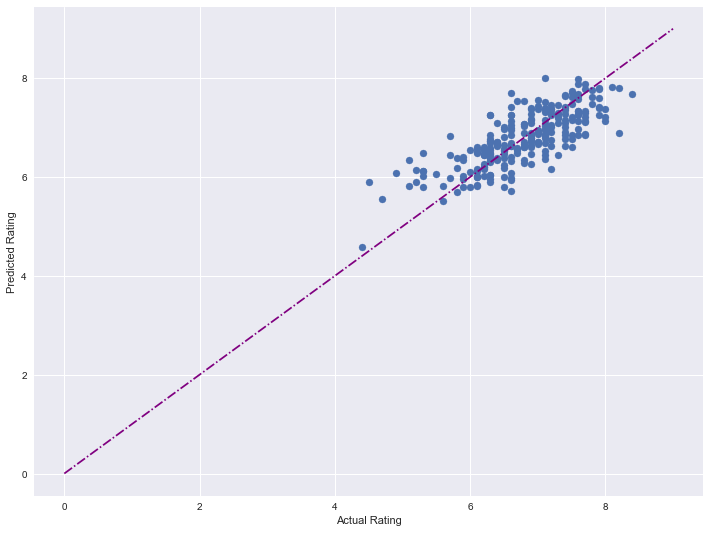

In [632]:
plt.figure(figsize = (12,9))

plt.plot(range(10), range(10), color = 'purple', linestyle = 'dashdot')
plt.scatter(y3_test, lcv.predict(X3_test))
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

One more visualization, but with different colors